## This notebook has the goal of making the Mixture of Factor Analyzers (MFA) model, along with benchmark models

The models are to be saved to a models-folder in the project. 
As a benchmark-model, PCA is to be used. Further benchmark-models might be added. 
Trainingtime for each model should be noted.

In [1]:
import torch
import glob
import matplotlib.pyplot as plt
from MFA import MFA
from utils import get_data, reconstruct_mfa, calculate_rmse, calculate_sam
from enum import Enum
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hypso import Hypso
import numpy as np

### fetching training-data
The training-data consists of a subsample of pixels taken from vastly different geographical places. The image was choosen to deliberatly include both water and land pixels for there to naturally be more classes for the model to describe. 

in "01_model_testing.ipynb", the trained models will be tested on new pixels.

In [2]:
class DataProduct(Enum):
    L1A = 'l1a'
    L1B = 'l1b'
    L1D = 'l1d'

class PreprocessingMethod(Enum):
    L2 = 'L2'
    MEAN_CENTERING = 'MeanCentering'
    SCALING = 'Scaling'
    NONE = 'None'

In [3]:
data_product = DataProduct.L1B 

PREPROCESSING_METHOD = PreprocessingMethod.MEAN_CENTERING

In [4]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = glob.glob(f'data/training_{data_product.value}/*.nc')
print(f"Found {len(data_dir)} files.")

Using device: cpu
Found 44 files.


### Determine if we add spatial features
Tests have shown that adding spatial features (Convalutional operation of 3x3), the RMSE and SAM is massivly improved for the MFA. 
This improvement is not found with the PCA-model, and the reason as for why this is remains unclear.

In practice, this is done by performing a convolution operation on all pixels, and adding the average of each band as a new band. This increases the feature-size from 120 to 240.

In [5]:
target_total_samples = 200000

data_list = get_data(data_dir, data_product.value, target_total_samples)

data = torch.from_numpy(data_list).float().to(device)

Aiming to extract ~4545 pixels per file from 44 files to reach a total of ~200000 samples.
1/44 | File: data/training_l1b\aeronetgalata_2025-01-02T08-18-16Z-l1b.nc | Extracted 4545 pixels.
2/44 | File: data/training_l1b\algeria_2022-10-29T09-44-03Z-l1b.nc | Extracted 4545 pixels.
3/44 | File: data/training_l1b\amazonia_2024-09-21T13-12-47Z-l1b.nc | Extracted 4545 pixels.
4/44 | File: data/training_l1b\annapolis_2025-08-04T15-25-40Z-l1b.nc | Extracted 4545 pixels.
5/44 | File: data/training_l1b\antarctica_2022-11-20T08-44-35Z-l1b.nc | Extracted 4545 pixels.
6/44 | File: data/training_l1b\barfire_2025-08-04T09-11-36Z-l1b.nc | Extracted 4545 pixels.
7/44 | File: data/training_l1b\bermuda_2024-07-16T14-27-21Z-l1b.nc | Extracted 4545 pixels.
8/44 | File: data/training_l1b\blacksea2_2024-07-21T07-40-44Z-l1b.nc | Extracted 4545 pixels.
9/44 | File: data/training_l1b\capedyer_2023-10-16T14-54-55Z-l1b.nc | Extracted 4545 pixels.
10/44 | File: data/training_l1b\capescott_2023-05-09T19-29-59Z-l1b

## Look for outliers or dead pixels

Iterating over the pixels to see if any are all zero or all max

In [6]:
# We check if ALL values along the last dimension (bands) are 0
dead_pixel_mask = (data == 0).all(dim=-1)

# Get the indices/coordinates of the dead pixels
dead_pixel_indices = torch.nonzero(dead_pixel_mask)

# Check how many dead pixels were found
print(f"Number of dead pixels: {dead_pixel_indices.shape[0]}")

Number of dead pixels: 0


## Making the MFA Model

### Model Selection
Determining the optimal model order—specifically the number of mixture components ($K$) and the dimensionality of the latent factor space ($q$)—is a critical step to prevent overfitting. The literature emphasizes two primary methods for this selection process:
1. **The Information Criteria Approach (BIC)**

Source: McLachlan, G., & Peel, D. (2000). *Finite Mixture Models.*

This approach involves performing a grid search over potential $(K, q)$ combinations. For each combination, we calculate the Bayesian Information Criterion (BIC) and select the pair with the lowest BIC score. This metric balances goodness-of-fit with model complexity:$$\text{BIC} = -2 \ln(\mathcal{L}) + d \ln(n)$$
Where:
$\mathcal{L}$ is the maximized likelihood of the model.
$d$ is the number of free parameters.
$n$ is the number of observations.

2. **The Log Likelyhood Approach (LL)**

This approach involves performing a grid search over potential $(K, q)$ combinations. For each combination, we calculate the Log-Likelyhood (LL) and select the pair with the highest LL. Intuitivly, the Log-Likelyhood is the logarithm of the likelyhood of observing the data, given the model?

3. **The Variational Bayesian Approach (VB)**

Source: Ghahramani, Z., & Beal, M. J. (2000). *Variational Inference for Bayesian Mixtures of Factor Analysers.*

Unlike the BIC grid search, the Variational Bayesian method treats model selection as an integral part of the optimization process itself, rather than a post-hoc comparison.
Mechanism: It places Dirichlet priors on the mixing coefficients and Automatic Relevance Determination (ARD) priors on the factor loading matrices.
Result: As the model trains, it automatically drives the coefficients of unnecessary components or factors to zero, effectively selecting the model structure in a single run.

## Choosen approach
1. Perform PCA on the entire dataset. If a single PCA model can describe >99.5% of the variance with *N* number of components, then we set *N* as the ceiling for our BIC-method. Source: Bioucas-Dias, J. M., & Nascimento, J. M. (2008). *Hyperspectral Subspace Identification.*

2. Sample a subset of the pixels 10,000 - 50,000 pixels. Source: Banfield, J. D., & Raftery, A. E. (1993). *Model-Based Gaussian and Non-Gaussian Clustering.*

3. Perform the grid search on the sampled pixels.

4. Retrain the optimal combinantion on the complete dataset.

### 1. Make PCA-model

------------------------------
Cumulative Variance for top 10 components:
 tensor([0.9008, 0.9598, 0.9840, 0.9937, 0.9955, 0.9971, 0.9981, 0.9986, 0.9990,
        0.9993])
------------------------------
Number of components to explain 99.5% variance: 5
Ceiling for q (latent factors) set to: 5
PCA model saved to 'models/pca_benchmark_DataProduct.L1B_MeanCentering.pt'


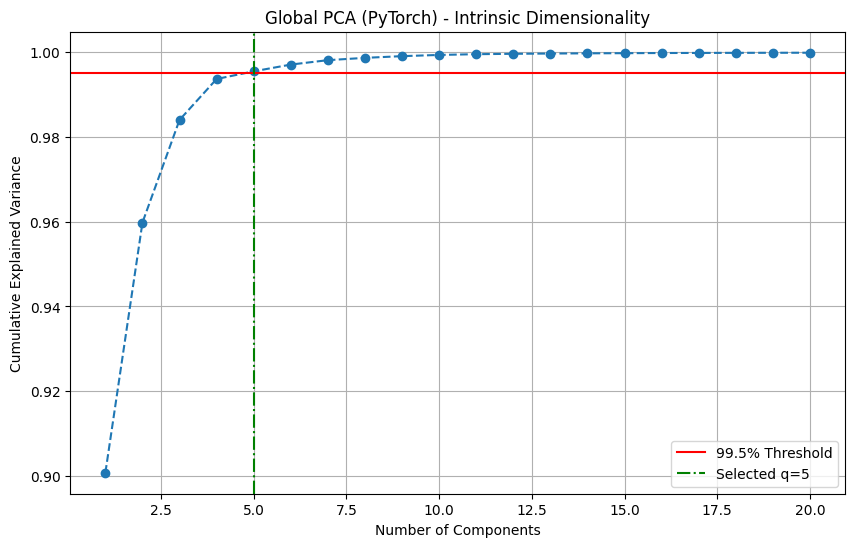

In [7]:
# 1. Mean Centering
mean_vector = data.mean(dim=0)
X_centered = data - mean_vector

# 2. Compute Covariance Matrix
n_samples = X_centered.shape[0]
cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)

# 3. Eigendecomposition (PCA)
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

# 4. Sort indices in descending order (eigh returns ascending)
sorted_indices = torch.argsort(eigenvalues, descending=True)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_components = eigenvectors[:, sorted_indices]

# 5. Calculate Cumulative Variance
total_variance = sorted_eigenvalues.sum()
explained_variance_ratio = sorted_eigenvalues / total_variance
cum_var = torch.cumsum(explained_variance_ratio, dim=0)

# 6. Find the threshold (99.5%)
threshold = 0.995
n_components_995 = (cum_var >= threshold).nonzero(as_tuple=False)[0].item() + 1

print("-" * 30)
print(f"Cumulative Variance for top 10 components:\n {cum_var[:10]}")
print("-" * 30)
print(f"Number of components to explain {threshold*100}% variance: {n_components_995}")
print(f"Ceiling for q (latent factors) set to: {n_components_995}")

# 7. Save the PCA Model
pca_state = {
    'components': sorted_components[:, :n_components_995], # Save only needed components
    'mean': mean_vector,
    'explained_variance': sorted_eigenvalues[:n_components_995],
    'n_components_995': n_components_995
}

torch.save(pca_state, f'models/pca_benchmark_{data_product}_{PREPROCESSING_METHOD.value}.pt')
print(f"PCA model saved to 'models/pca_benchmark_{data_product}_{PREPROCESSING_METHOD.value}.pt'")

# Move to CPU for plotting
cum_var_np = cum_var.cpu().numpy()
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cum_var_np[:20], marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'{threshold*100}% Threshold')
plt.axvline(x=n_components_995, color='g', linestyle='-.', label=f'Selected q={n_components_995}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Global PCA (PyTorch) - Intrinsic Dimensionality')
plt.legend()
plt.grid(True)
plt.show()

### 2. Subsample the dataset

In [8]:
N_SUBSET = 50000 
torch.manual_seed(42)

# Generate random indices
if data.shape[0] > N_SUBSET:
    # random_split or randperm is standard torch practice
    indices = torch.randperm(data.shape[0])[:N_SUBSET]
    data_subset = data[indices]
    print(f"Subsampled data from {data.shape[0]} to {data_subset.shape[0]} samples.")
else:
    print("Dataset smaller than requested subset. Using full data.")
    data_subset = data

print(f"Subset shape: {data_subset.shape}")

Subsampled data from 199980 to 50000 samples.
Subset shape: torch.Size([50000, 120])


### Perform Log-Likelyhood Grid Search

We hold out 10% of the training-samples, and train the MFA on the remainding 90%. For each batch, we calculate the out-of-sample log-likelyhood of the model explaining the pixels. 

Starting Out-of-Sample Log-Likelihood Grid Search.
Training on 40000 samples, Testing on 10000 samples.
Appliying Mean Centering to data
Completed 1/24 - K=3, q=2, Test LL=-283.5292
Completed 2/24 - K=3, q=3, Test LL=-246.0191
Completed 3/24 - K=3, q=4, Test LL=-192.4112
Completed 4/24 - K=3, q=5, Test LL=-184.4109
Completed 5/24 - K=4, q=2, Test LL=-257.6721
Completed 6/24 - K=4, q=3, Test LL=-208.6954
Completed 7/24 - K=4, q=4, Test LL=-191.5317
Completed 8/24 - K=4, q=5, Test LL=-158.5937
Completed 9/24 - K=5, q=2, Test LL=-241.3757
Completed 10/24 - K=5, q=3, Test LL=-204.2732
Completed 11/24 - K=5, q=4, Test LL=-175.1568
Completed 12/24 - K=5, q=5, Test LL=-147.9010
Completed 13/24 - K=6, q=2, Test LL=-235.4333
Completed 14/24 - K=6, q=3, Test LL=-198.0562
Completed 15/24 - K=6, q=4, Test LL=-165.5317
Completed 16/24 - K=6, q=5, Test LL=-140.8789
Completed 17/24 - K=7, q=2, Test LL=-228.9996
Completed 18/24 - K=7, q=3, Test LL=-189.4870
Completed 19/24 - K=7, q=4, Test LL=-159.607

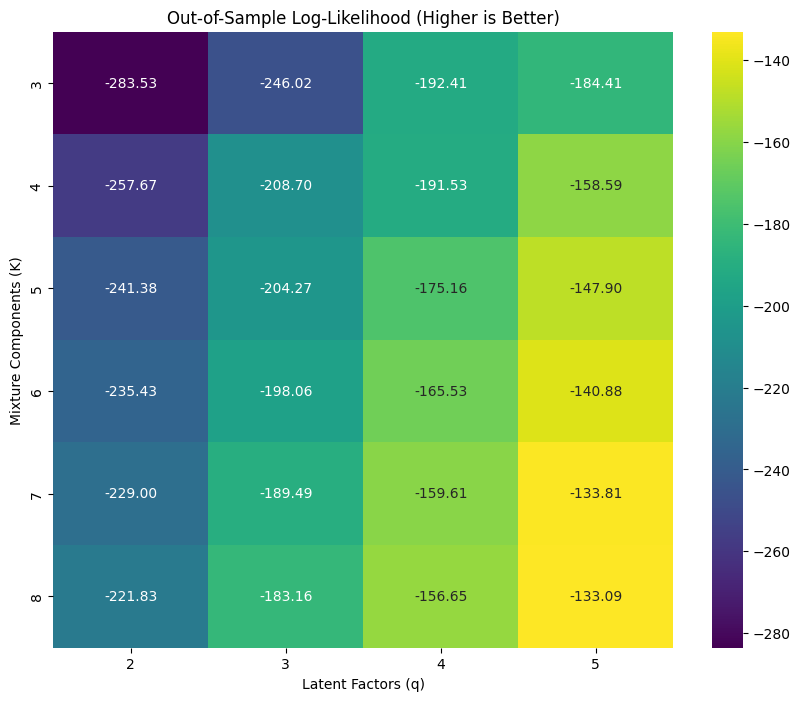

In [ ]:
torch.manual_seed(42)

# Grid Configuration
k_range = range(3, 9, 1)
# Calculate ceiling and add safety buffer (Assuming n_components_995 is defined earlier)
q_ceiling = max(n_components_995, 5) 
q_range = range(2, q_ceiling + 1) 

# Split into Train/Test (80/20)
train_size = int(0.8 * len(data_subset))
test_size = len(data_subset) - train_size
X_train_dataset, X_test_dataset = torch.utils.data.random_split(data_subset, [train_size, test_size])

# Extract the actual tensors from the Subset objects
X_train = data_subset[X_train_dataset.indices]
X_test = data_subset[X_test_dataset.indices]

print(f"Starting Out-of-Sample Log-Likelihood Grid Search.")
print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples.")

match PREPROCESSING_METHOD:
    case PreprocessingMethod.MEAN_CENTERING:
        print("Appliying Mean Centering to data")
        train_mean = X_train.mean(dim=0)
        X_train_processed = X_train - train_mean
        X_test_processed = X_test - train_mean

    case PreprocessingMethod.SCALING:
        print("Scaling data")
        train_max = X_train.max()
        print(f"Training Max Value: {train_max}")
        # Scale both using train_max
        X_train_processed = X_train / train_max
        X_test_processed = X_test / train_max

    case PreprocessingMethod.L2:
        print("Applying L2 Normalization to data")
        norms = torch.norm(X_train, p=2, dim=1, keepdim=True)
        epsilon = 1e-8
        X_train_processed = X_train / (norms + epsilon)
        norms_test = torch.norm(X_test, p=2, dim=1, keepdim=True)
        X_test_processed = X_test / (norms_test + epsilon)

    case PreprocessingMethod.NONE:
        print("No preprocessing applied to data")
        X_train_processed = X_train
        X_test_processed = X_test

# THE GRID SEARCH LOOP 
results_list = []
i = 1
total_iters = len(k_range) * len(q_range)

for k in k_range:
    for q in q_range:
        if q >= 120: 
            continue
            
        try: 
            # Initialize model
            model = MFA(n_components=k, n_features=X_train_processed.shape[1], n_factors=q, device=device)
            
            model.initialize_parameters(X_train_processed)
            model.fit(X_train_processed)

            # CALCULATE OUT-OF-SAMPLE LOG-LIKELIHOOD 
            with torch.no_grad(): # Don't track gradients for testing
                
                _, log_likelihood_per_pixel = model.e_step(X_test_processed)
                out_of_sample_ll = log_likelihood_per_pixel.mean().item()
    
            results_list.append({'K': k, 'q': q, 'Test_Log_Likelihood': out_of_sample_ll})
            
            print(f"Completed {i}/{total_iters} - K={k}, q={q}, Test LL={out_of_sample_ll:.4f}")

            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Failed for K={k}, q={q}: {e}")
            
        i += 1

# VISUALIZATION 
if len(results_list) > 0:
    results_df = pd.DataFrame(results_list)

    # Find optimal (For Log-Likelihood, HIGHER IS BETTER)
    best_row = results_df.loc[results_df['Test_Log_Likelihood'].idxmax()]
    print("-" * 30)
    print(f"Best Model configuration: K={int(best_row['K'])}, q={int(best_row['q'])}")
    print("-" * 30)

    # Pivot for Heatmap
    ll_pivot = results_df.pivot(index="K", columns="q", values="Test_Log_Likelihood")

    plt.figure(figsize=(10, 8)) 
    # Use standard viridis. HIGHER is better, so the brightest yellow is your best model.
    sns.heatmap(ll_pivot, annot=True, fmt=".2f", cmap="viridis") 
    
    plt.title("Out-of-Sample Log-Likelihood (Higher is Better)")
    plt.xlabel("Latent Factors (q)")
    plt.ylabel("Mixture Components (K)")
    plt.show()

    K_optimal = int(best_row['K'])
    q_optimal = int(best_row['q'])
else:
    print("No results to plot.")

### Retrain the model on the complete dataset 

In [18]:
match PREPROCESSING_METHOD:
    case PreprocessingMethod.MEAN_CENTERING:
        print("Appliying Mean Centering to data")
        X = data - data.mean(dim=0)
        
    case PreprocessingMethod.SCALING:
        print("Scaling data")
        max = data.max()
        print(f"Data Max Value: {max}")
        # Scale both using train_max
        X = data / max

    case PreprocessingMethod.L2:
        print("Applying L2 Normalization to data")
        norms = torch.norm(data, p=2, dim=1, keepdim=True)
        epsilon = 1e-8
        X = data / (norms + epsilon)

    case PreprocessingMethod.NONE:
        print("No preprocessing applied to data")
        X = data

# Ensure float32
X = X.float()
print(f"Shape of X: {X.shape}")

#Parameters found above
K = K_optimal
q = q_optimal
mfa_model = MFA(n_components=K, n_features=X.shape[1], n_factors=q, device=device)

mfa_model.initialize_parameters(X)

# Fit
mfa_model.fit(X)
# Clean up memory if using GPU
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Save model
mfa_state = {
    # model.state_dict() automatically grabs log_pi, mu, Lambda, log_psi
    'model_state_dict': mfa_model.state_dict(), 
    
    # Hyperparameters (Required to re-initialize the class) --
    'hyperparameters': {
        'n_components': K,
        'n_features': X.shape[1],
        'n_factors': q
    },
    
    # Preprocessing Stats
    'preprocessing': {
        'data_max': data.max(),
        'mean': data.mean(dim=0)          
    },
    
    # Metadata 
    'metrics': {
        'final_ll': getattr(mfa_model, 'final_ll', None)
    }
}

save_path = f'models/preprocessing_comparison/mfa_k{K}_q{q}_{data_product.value}_{PREPROCESSING_METHOD.value}.pt'
torch.save(mfa_state, save_path)
print(f"MFA model saved to '{save_path}'")

Appliying Mean Centering to data
Shape of X: torch.Size([199980, 120])
MFA model saved to 'models/preprocessing_comparison/mfa_k8_q5_l1b_MeanCentering.pt'


## Model testing

Model testing consists of 3 main tests

1. **Reconstruction:** The RMSE and SAM is calculated for reconstruction from latent space for both the MFA and the result is compared to the PCA-model

2. **Clasification:** An visual classification test is performed. In this test a colour is given to each factor, and for a given image, each pixel is assinged a Factor. A visual test is performed to see if the creared clusters represents physical materials.

3. **Loadings:** For each loading, *mu* is plotted. The object is to see how *mu* differs for each Factor. If for the factors *mu* has the same shape but diffrent intensity, that is evidense for the model only capturing differnet light intensities and clustering based on those. if *mu* has different shapes, it is evident that the model has learn usefull spectra. Preferably, *mu* should resemble the spectra of vegetation, ocean, cloud, etc.  

In [19]:
test_data_dir = glob.glob(f'data/testing_{data_product.value}/*.nc')
print(f"Found {len(test_data_dir)} files.")

target_total_samples = 10000

test_data_list = get_data(test_data_dir, data_product.value, target_total_samples)

test_data = torch.from_numpy(test_data_list).float().to(device)

Found 8 files.
Aiming to extract ~1250 pixels per file from 8 files to reach a total of ~10000 samples.
1/8 | File: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc | Extracted 1250 pixels.
2/8 | File: data/testing_l1b\lacrau_2025-01-17T09-40-10Z-l1b.nc | Extracted 1250 pixels.
3/8 | File: data/testing_l1b\lakevolta_2023-01-19T09-40-06Z-l1b.nc | Extracted 1250 pixels.
4/8 | File: data/testing_l1b\mwanza_2022-07-21T07-43-03Z-l1b.nc | Extracted 1250 pixels.
5/8 | File: data/testing_l1b\princeWilliam_2022-12-09T19-57-47Z-l1b.nc | Extracted 1250 pixels.
6/8 | File: data/testing_l1b\svalbard_2022-07-31T11-43-59Z-l1b.nc | Extracted 1250 pixels.
7/8 | File: data/testing_l1b\uijsselmeer_2024-10-22T09-53-08Z-l1b.nc | Extracted 1250 pixels.
8/8 | File: data/testing_l1b\wildfirePerth_2025-03-17T01-54-12Z-l1b.nc | Extracted 1250 pixels.
------------------------------
Final Analysis Dataset Shape: (10000, 120)


#### Reconstruction

In [20]:
with torch.no_grad():
    # Flatten Data to 2D
    X_raw = test_data.clone().detach().to(dtype=torch.float32, device=device)
    if X_raw.ndim == 3:
        X_raw = X_raw.reshape(-1, X_raw.shape[-1])

    match PREPROCESSING_METHOD:
        case PreprocessingMethod.MEAN_CENTERING:
            print("Appliying Mean Centering to data")
            X = X_raw - mfa_state['preprocessing']['mean']
        
        case PreprocessingMethod.SCALING:
            print("Scaling data")
            X = X_raw / mfa_state['preprocessing']['data_max']

        case PreprocessingMethod.L2:
            print("Applying L2 Normalization to data")
            norms = torch.norm(X_raw, p=2, dim=1, keepdim=True)
            epsilon = 1e-8
            X = X_raw / (norms + epsilon)
            
        case PreprocessingMethod.NONE:
            print("No preprocessing applied to data")
            X = X_raw.float()
    
    # MFA Benchmarks
    X_rec_mfa_shape, cluster_ids = reconstruct_mfa(mfa_model, X)
    match PREPROCESSING_METHOD:
        case PreprocessingMethod.SCALING:
            X_rec_mfa_physical = X_rec_mfa_shape * mfa_state['preprocessing']['data_max'] # Restore magnitude
        case PreprocessingMethod.MEAN_CENTERING:
            X_rec_mfa_physical = X_rec_mfa_shape + mfa_state['preprocessing']['mean'] # Restore magnitude
        case PreprocessingMethod.L2:
            pixel_norms = torch.linalg.norm(X_raw, dim=1, keepdim=True).clamp(min=1e-8)
            X_rec_mfa_physical = X_rec_mfa_shape * pixel_norms # Restore magnitude
        case PreprocessingMethod.NONE:
            X_rec_mfa_physical = X_rec_mfa_shape
    
    rmse_mfa = calculate_rmse(X_raw, X_rec_mfa_physical)
    sam_mfa = calculate_sam(X_raw, X_rec_mfa_physical)

    print("=== MFA Reconstruction Benchmark ===")
    print(f"MFA (K={mfa_model.K}, q={q_optimal}): RMSE = {rmse_mfa:.4f}, SAM = {sam_mfa:.4f}")

    # Clear variables to free memory for PCA benchmark
    del X_rec_mfa_shape, X_rec_mfa_physical


    # PCA Benchmarks
    Z_pca = torch.matmul(X_raw - pca_state['mean'], pca_state['components'])
    X_rec_pca_shape = torch.matmul(Z_pca, pca_state['components'].T) + pca_state['mean']
    rmse_pca = calculate_rmse(X_raw, X_rec_pca_shape)
    sam_pca = calculate_sam(X_raw, X_rec_pca_shape)

    print("=== PCA Reconstruction Benchmark ===")
    print(f"PCA (q={q_optimal}): RMSE = {rmse_pca:.4f}, SAM = {sam_pca:.4f}")


Appliying Mean Centering to data
=== MFA Reconstruction Benchmark ===
MFA (K=8, q=5): RMSE = 1.9565, SAM = 0.0306
=== PCA Reconstruction Benchmark ===
PCA (q=5): RMSE = 2.3663, SAM = 0.0453


In [21]:
del X_raw, Z_pca, X_rec_pca_shape, test_data, test_data_list

#### Classification

Using 3 files for testing.
Processing file: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc
Image Shape: 598x1092 with 120 bands


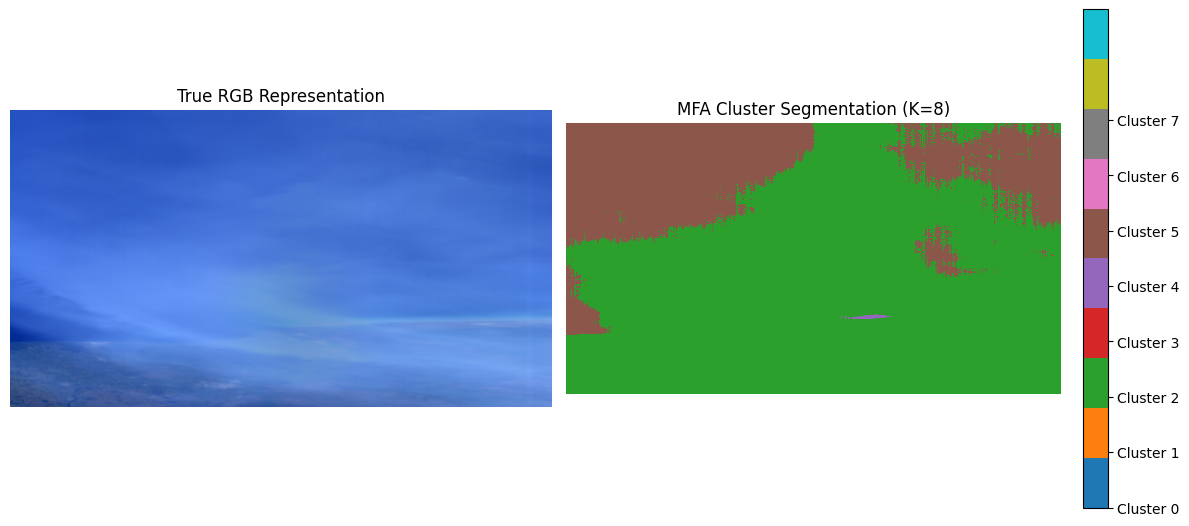

Processing file: data/testing_l1b\lacrau_2025-01-17T09-40-10Z-l1b.nc
Image Shape: 598x1092 with 120 bands


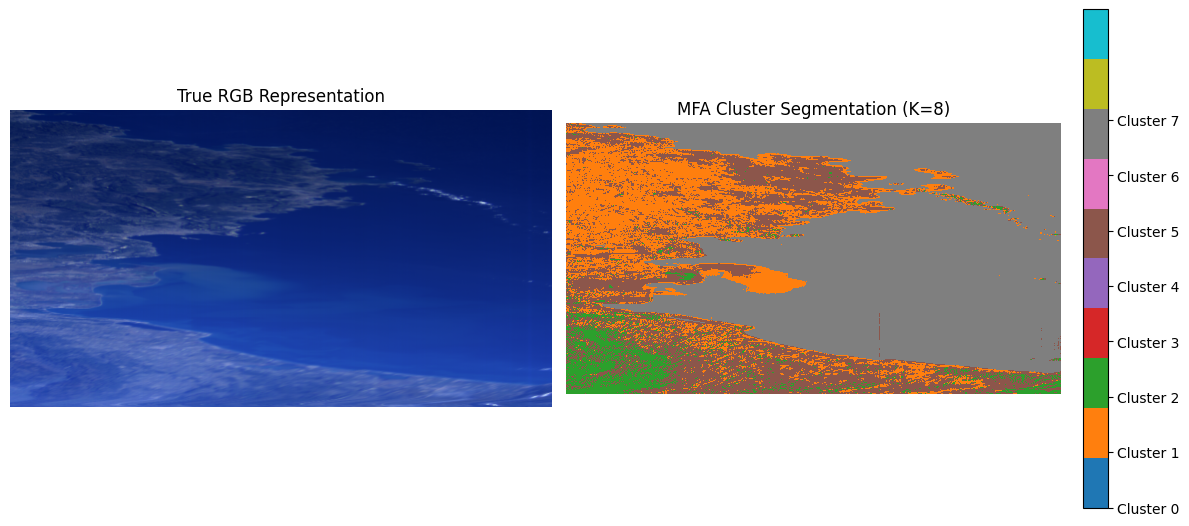

Processing file: data/testing_l1b\lakevolta_2023-01-19T09-40-06Z-l1b.nc
Image Shape: 956x684 with 120 bands


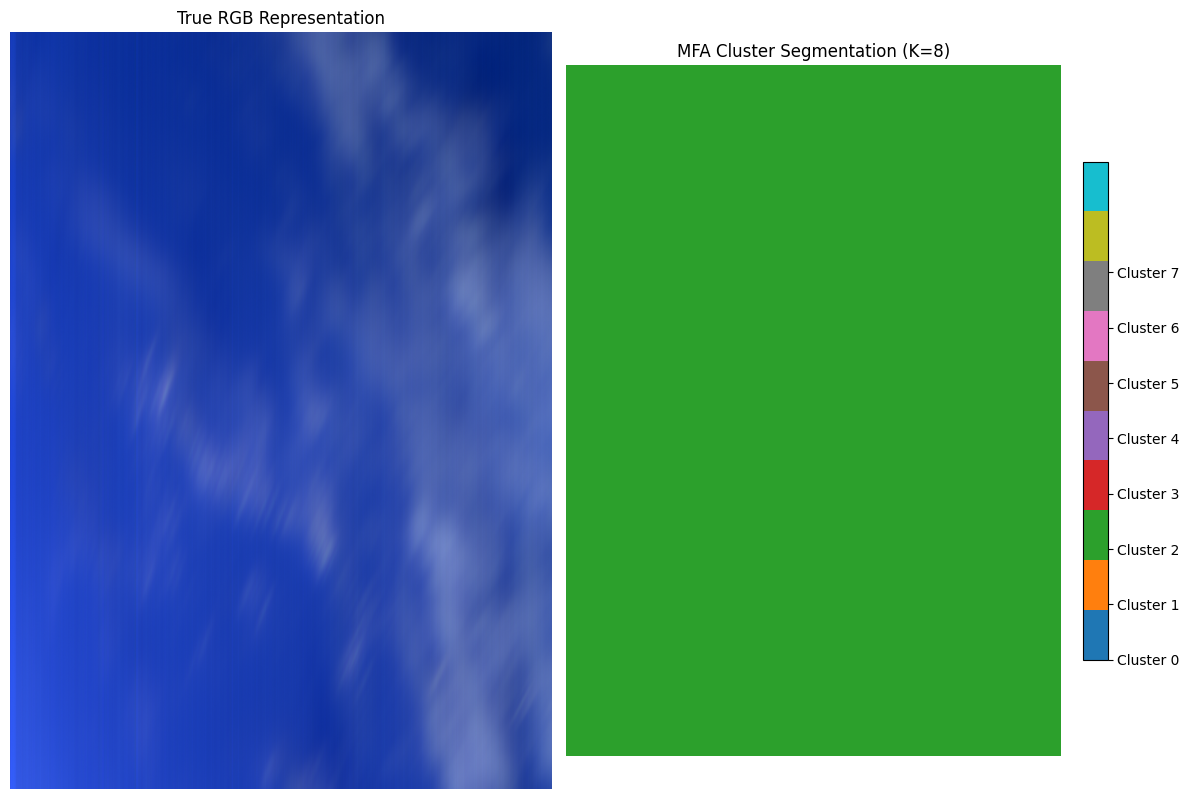

In [22]:
NUM_TEST_FILES = 3

num_test_files = min(NUM_TEST_FILES, len(data_dir))
print(f"Using {num_test_files} files for testing.")

#Fetching files from the testing directory 
for i in range(num_test_files):
    file = test_data_dir[i]
    print(f"Processing file: {file}")

    satobj = Hypso(file) 

    # Load the full image data
    match data_product:
        case DataProduct.L1A:
            image = satobj.l1a_cube.values.astype(np.float32)
        case DataProduct.L1B:
            image = satobj.l1b_cube.values.astype(np.float32)
        case DataProduct.L1D:
            image = satobj.l1d_cube.values.astype(np.float32)
        case _:
            raise ValueError(f"Unknown data product: {data_product}")

    h, w, b = image.shape
    print(f"Image Shape: {h}x{w} with {b} bands")

    # Flatten the full image for the model
    data_2d_full = image.reshape(-1, b) # Shape: (Total_Pixels_In_Image, 120)

    # Preprocess the full image
    # We must use the same stats we used for the random test set
    data_2d_full_tensor = torch.tensor(data_2d_full, dtype=torch.float32).to(device)
    match PREPROCESSING_METHOD:
        case PreprocessingMethod.MEAN_CENTERING:
            processed_image = data_2d_full_tensor - mfa_state['preprocessing']['mean']
        case PreprocessingMethod.SCALING:
            processed_image = data_2d_full_tensor / mfa_state['preprocessing']['data_max'] 
        case PreprocessingMethod.L2:
            norms = torch.norm(data_2d_full_tensor, p=2, dim=1, keepdim=True)
            epsilon = 1e-8
            processed_image = (data_2d_full_tensor / (norms + epsilon))
        case PreprocessingMethod.NONE:
            processed_image = data_2d_full_tensor.float()

    # Run Inference to get NEW cluster_ids for this specific image
    with torch.no_grad():
        # We only need the responsibilities to get the argmax (cluster id)
        log_resp, _ = mfa_model.e_step(processed_image)
        responsibilities = torch.exp(log_resp)
        new_cluster_ids = torch.argmax(responsibilities, dim=1)

    # reshape the new IDs
    seg_map = new_cluster_ids.reshape(h, w).cpu().numpy()

    # Get RGB for comparison (Bands 70, 50, 20 approx for Hypso)
    rgb_bands = [70, 50, 20]
    rgb_img = image[:, :, rgb_bands]
    # Normalize RGB for display
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

    fig, ax = plt.subplots(1, 2, figsize=(12, 8))

    # 2. Plot True RGB
    # aspect='equal' ensures 1 pixel is square (fixes the squashing)
    ax[0].imshow(rgb_img, aspect='equal') 
    ax[0].set_title("True RGB Representation")
    ax[0].axis('off')

    # 3. Plot Segmentation Map using imshow instead of heatmap
    # cmap='tab10': Good distinct colors for categorical data
    # interpolation='nearest': Keeps edges sharp (no blurring between classes)
    # aspect='equal': Matches the geometry of the RGB image exactly
    # vmax=K: Ensures the colormap covers the correct range of clusters
    im = ax[1].imshow(seg_map, cmap='tab10', vmin=0, vmax=9, interpolation='nearest', aspect='equal')
    ax[1].set_title(f"MFA Cluster Segmentation (K={mfa_model.K})")
    ax[1].axis('off')

    # Optional: Update the legend/colorbar to reflect only the active K clusters
    cbar = plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
    cbar.set_ticks(np.arange(mfa_model.K)) # Only put ticks for the clusters we actually have
    cbar.set_ticklabels([f"Cluster {k}" for k in range(mfa_model.K)]) 

    plt.tight_layout()
    plt.show()

Using 3 files for testing.
Found 4 models in 'models/preprocessing_comparison/'
Processing file 1/3: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc
Processing file 2/3: data/testing_l1b\lacrau_2025-01-17T09-40-10Z-l1b.nc
Processing file 3/3: data/testing_l1b\lakevolta_2023-01-19T09-40-06Z-l1b.nc


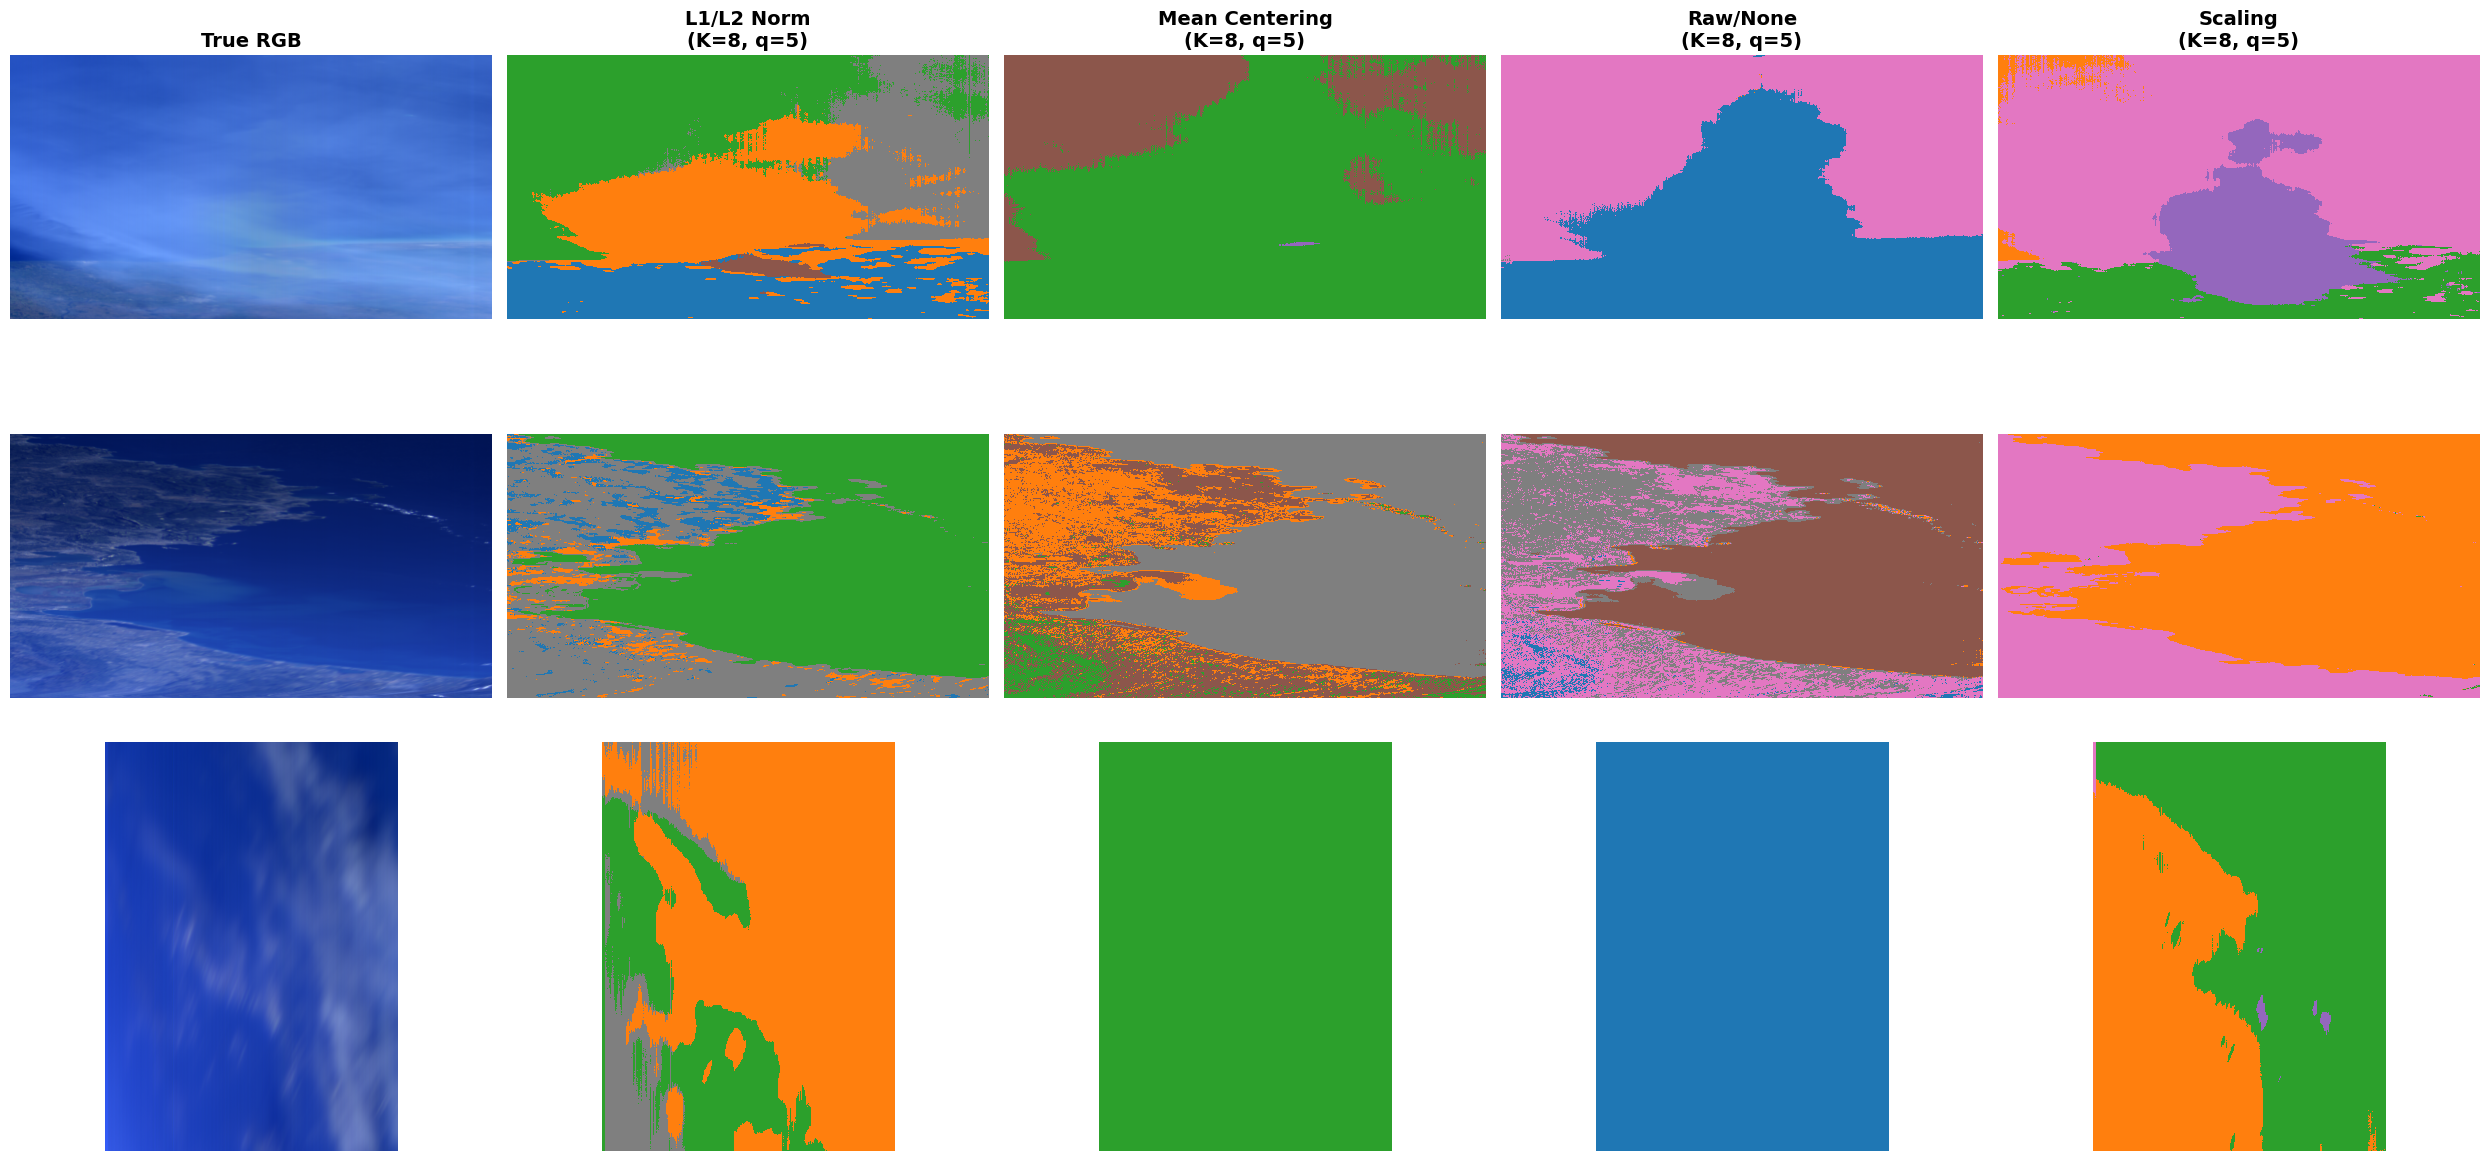

In [23]:
import os

NUM_TEST_FILES = 3
num_test_files = min(NUM_TEST_FILES, len(data_dir))
print(f"Using {num_test_files} files for testing.")

# 1. Fetch all model files in the comparison folder
model_dir = "models/preprocessing_comparison/"
# Finds all .pt files and sorts them alphabetically
model_files = sorted(glob.glob(os.path.join(model_dir, "*.pt")))
num_models = len(model_files)

print(f"Found {num_models} models in '{model_dir}'")

# Create the figure grid: h rows (images), w columns (1 RGB + num_models)
h = num_test_files
w = 1 + num_models

# Scale figure size dynamically based on the grid width/height
fig, axes = plt.subplots(h, w, figsize=(w * 5, h * 4))

# Ensure axes is a 2D array even if h=1 or w=1
if h == 1:
    axes = np.expand_dims(axes, axis=0)
if w == 1:
    axes = np.expand_dims(axes, axis=1)

# 2. Pre-load all models to avoid constantly reloading them inside the image loop
loaded_models = []
for model_file in model_files:
    mfa_state = torch.load(model_file, map_location=device)
    
    # Extract params
    K = mfa_state['hyperparameters']['n_components']
    q = mfa_state['hyperparameters']['n_factors']
    n_features = mfa_state['hyperparameters']['n_features']
    
    # Initialize Model
    mfa_model = MFA(n_components=K, n_features=n_features, n_factors=q, device=device)
    mfa_model.load_state_dict(mfa_state['model_state_dict'])
    mfa_model.eval()
    
    # Deduce the preprocessing method from filename string (safest approach)
    filename = os.path.basename(model_file)
    if "MeanCentering" in filename:
        model_title = f"Mean Centering\n(K={K}, q={q})"
    elif "Scaling" in filename:
        model_title = f"Scaling\n(K={K}, q={q})"
    elif "L2" in filename:
        model_title = f"L1/L2 Norm\n(K={K}, q={q})"
    else:
        model_title = f"Raw/None\n(K={K}, q={q})"
        
    loaded_models.append({
        'model': mfa_model,
        'state': mfa_state,
        'filename': filename,
        'title': model_title
    })

# 3. Loop over the test images
for i in range(num_test_files):
    file = test_data_dir[i]
    print(f"Processing file {i+1}/{num_test_files}: {file}")

    satobj = Hypso(file) 

    # Load the full image data
    match data_product:
        case DataProduct.L1A:
            image = satobj.l1a_cube.values.astype(np.float32)
        case DataProduct.L1B:
            image = satobj.l1b_cube.values.astype(np.float32)
        case DataProduct.L1D:
            image = satobj.l1d_cube.values.astype(np.float32)
        case _:
            raise ValueError(f"Unknown data product: {data_product}")

    img_h, img_w, b = image.shape
    data_2d_full = image.reshape(-1, b)
    data_2d_full_tensor = torch.tensor(data_2d_full, dtype=torch.float32).to(device)

    # Get and Plot RGB Representation
    rgb_bands = [70, 50, 20]
    rgb_img = image[:, :, rgb_bands]
    # Normalize RGB for display
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
    
    axes[i, 0].imshow(rgb_img, aspect='equal')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title("True RGB", fontweight='bold', fontsize=14)

    # 4. Iterate through loaded models and plot classifications row-by-row
    for j, model_info in enumerate(loaded_models):
        mfa_model = model_info['model']
        mfa_state = model_info['state']
        filename = model_info['filename']
        
        # Apply the specific preprocessing mathematically based on filename
        if "MeanCentering" in filename:
            processed_image = data_2d_full_tensor - mfa_state['preprocessing']['mean']
        elif "Scaling" in filename:
            processed_image = data_2d_full_tensor / mfa_state['preprocessing']['data_max'] 
        elif "L2" in filename:
            norms = torch.norm(data_2d_full_tensor, p=2, dim=1, keepdim=True)
            epsilon = 1e-8
            processed_image = (data_2d_full_tensor / (norms + epsilon))
        else: # "None" or raw
            processed_image = data_2d_full_tensor.float()
                
        # Run Inference
        with torch.no_grad():
            log_resp, _ = mfa_model.e_step(processed_image)
            responsibilities = torch.exp(log_resp)
            new_cluster_ids = torch.argmax(responsibilities, dim=1)
            
        seg_map = new_cluster_ids.reshape(img_h, img_w).cpu().numpy()
        
        # Plot Classification Map
        # vmin=0, vmax=9 ensures stable tab10 colors across different models
        axes[i, j + 1].imshow(seg_map, cmap='tab10', vmin=0, vmax=9, interpolation='nearest', aspect='equal')
        axes[i, j + 1].axis('off')
        
        # Add titles only to the top row to keep the grid clean
        if i == 0:
            axes[i, j + 1].set_title(model_info['title'], fontweight='bold', fontsize=14)

# Render the beautiful master plot
plt.tight_layout()
plt.show()

#### Loadings Plotting

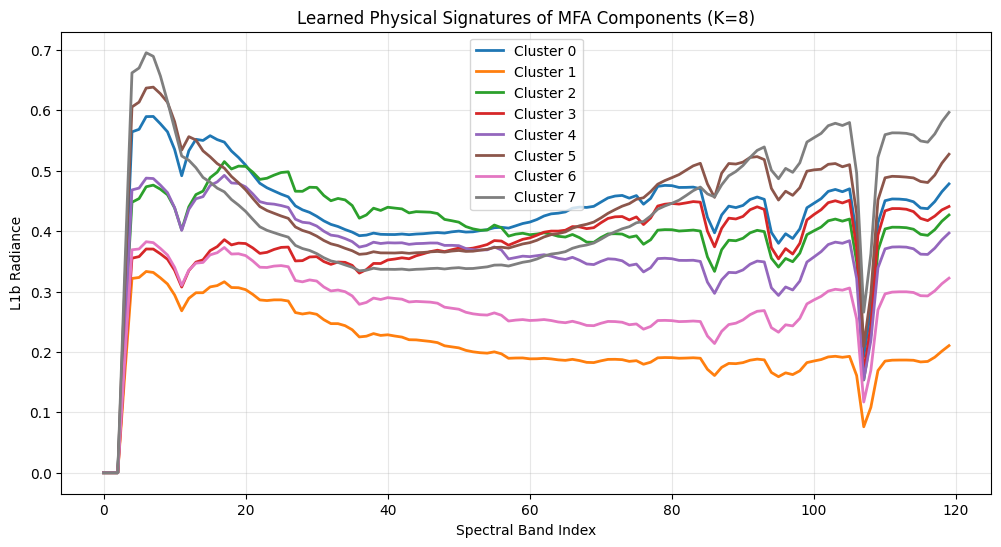

In [24]:
# Grab the discrete 'tab10' colormap directly
cmap = plt.get_cmap('tab10')

with torch.no_grad():
    # Extract the learned means (endmembers)
    learned_means = mfa_model.mu.cpu().numpy()
    
    # De-process them back to physical scale
    match PREPROCESSING_METHOD:
        case PreprocessingMethod.SCALING:
            physical_means = (learned_means + mfa_state['preprocessing']['mean'].cpu().numpy()) * mfa_state['preprocessing']['data_max'].cpu().numpy()
        case PreprocessingMethod.MEAN_CENTERING:
            physical_means = learned_means + mfa_state['preprocessing']['mean'].cpu().numpy()
        case PreprocessingMethod.L2:
            physical_means = learned_means * mfa_state['preprocessing']['data_max'].cpu().numpy() + mfa_state['preprocessing']['mean'].cpu().numpy()
        case PreprocessingMethod.NONE:
            physical_means = learned_means

plt.figure(figsize=(12, 6))

# Plot each cluster's mean spectral signature with a LOCKED color
for k in range(mfa_model.K):
    # .colors[k] explicitly grabs the k-th color from the tab10 palette
    plt.plot(physical_means[k], label=f'Cluster {k}', color=cmap.colors[k], linewidth=2)

plt.title(f"Learned Physical Signatures of MFA Components (K={mfa_model.K})")
plt.xlabel("Spectral Band Index")
plt.ylabel("L1b Radiance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Found 4 models in 'models/preprocessing_comparison/'


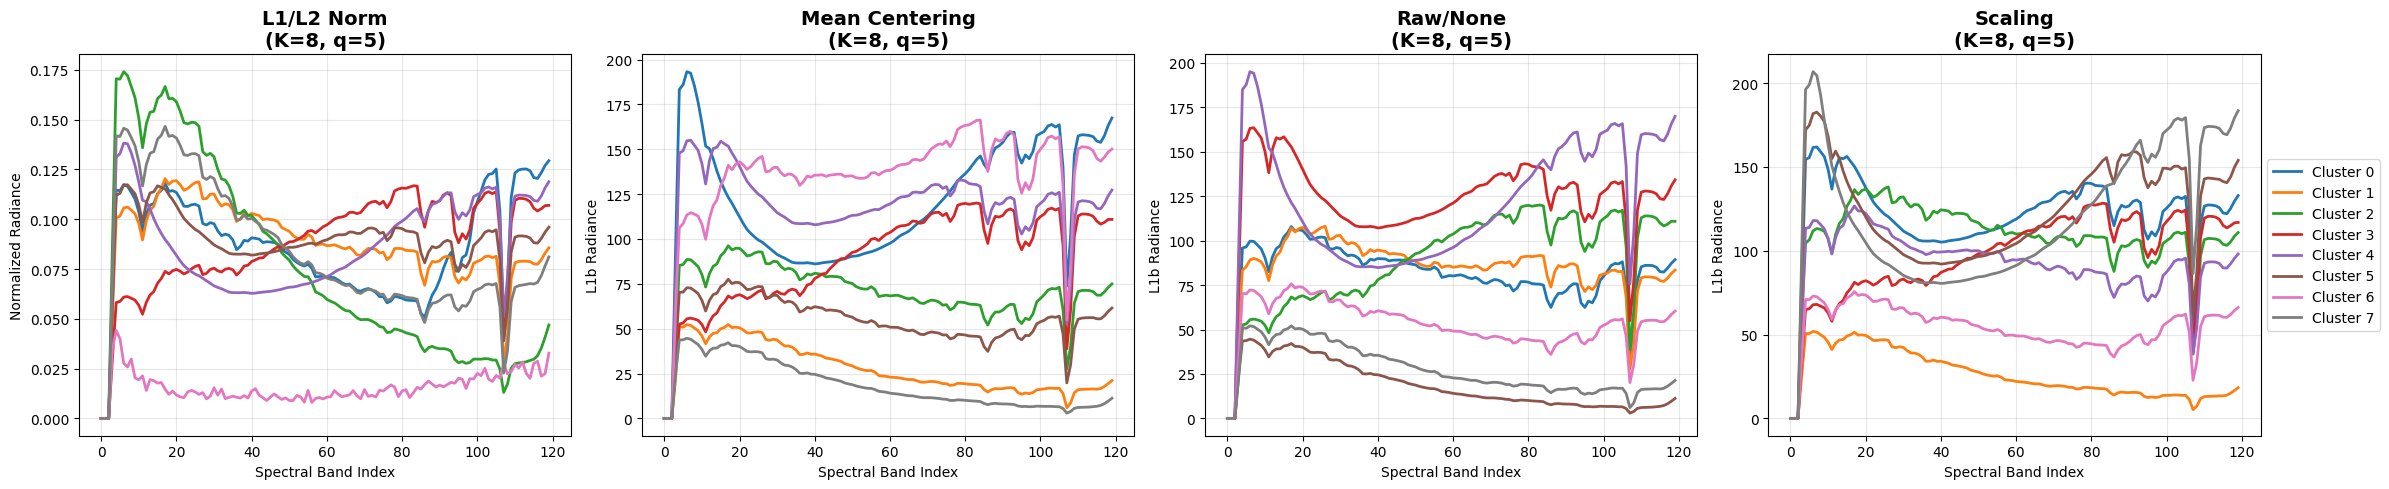

In [25]:
# 1. Fetch all model files in the comparison folder
model_dir = "models/preprocessing_comparison/"
model_files = sorted(glob.glob(os.path.join(model_dir, "*.pt")))
num_models = len(model_files)

print(f"Found {num_models} models in '{model_dir}'")

# Create the figure grid: 1 row, w columns (num_models)
# We use a 1D grid since we are just comparing line plots
fig, axes = plt.subplots(1, num_models, figsize=(num_models * 6, 5))

# Ensure axes is iterable even if there is only 1 model
if num_models == 1:
    axes = [axes]

# Grab the discrete 'tab10' colormap directly
cmap = plt.get_cmap('tab10')

# 2. Iterate through loaded models and plot signatures side-by-side
for j, model_file in enumerate(model_files):
    mfa_state = torch.load(model_file, map_location=device)
    
    # Extract params
    K = mfa_state['hyperparameters']['n_components']
    q = mfa_state['hyperparameters']['n_factors']
    n_features = mfa_state['hyperparameters']['n_features']
    
    # Initialize Model
    mfa_model = MFA(n_components=K, n_features=n_features, n_factors=q, device=device)
    mfa_model.load_state_dict(mfa_state['model_state_dict'])
    mfa_model.eval()
    
    # Extract learned means
    with torch.no_grad():
        learned_means = mfa_model.mu.cpu().numpy()
    
    filename = os.path.basename(model_file)
    
    # De-process the signatures based on filename string
    if "MeanCentering" in filename:
        title = f"Mean Centering\n(K={K}, q={q})"
        physical_means = learned_means + mfa_state['preprocessing']['mean'].cpu().numpy()
        ylabel = "L1b Radiance"
        
    elif "Scaling" in filename:
        title = f"Scaling\n(K={K}, q={q})"
        # Since training scaled via X = data / max, we simply multiply by max
        physical_means = learned_means * mfa_state['preprocessing']['data_max'].cpu().numpy()
        ylabel = "L1b Radiance"
        
    elif "L2" in filename:
        title = f"L1/L2 Norm\n(K={K}, q={q})"
        # L2 is learned on a unit hypersphere. We plot the normalized shapes.
        physical_means = learned_means
        ylabel = "Normalized Radiance"
        
    else: # "None" or raw
        title = f"Raw/None\n(K={K}, q={q})"
        physical_means = learned_means
        ylabel = "L1b Radiance"
            
    # Plot each cluster's mean spectral signature
    ax = axes[j]
    for k in range(K):
        ax.plot(physical_means[k], label=f'Cluster {k}', color=cmap.colors[k], linewidth=2)
        
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xlabel("Spectral Band Index")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    
    # Only show legend on the right-most plot to avoid clutter
    if j == num_models - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()